# Swin Transformer Functions

Import

In [1]:
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch
from bisect import bisect
import torch.nn.functional as F
import numpy as np
from random import choice

from torch.utils.data import Dataset
from PIL import Image
# import cv2
import os
from glob import glob
from torchvision import transforms, datasets
from torch.utils.data.dataset import Dataset
import math
import torch.utils.data as data

import random
import logging
import time

from datetime import datetime
import torchvision

import torch.optim as optim

import matplotlib.pyplot as plt

Swinjscc

In [2]:
# Modules

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, add_token=True, token_num=0, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape

        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))  # (N+1)x(N+1)

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww

        if add_token:
            attn[:, :, token_num:, token_num:] = attn[:, :, token_num:, token_num:] + relative_position_bias.unsqueeze(
                0)
        else:
            attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            if add_token:
                # padding mask matrix
                mask = F.pad(mask, (token_num, 0, token_num, 0), "constant", 0)
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm

    """

    def __init__(self, input_resolution, dim, out_dim=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        if out_dim is None:
            out_dim = dim
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, out_dim, bias=False)
        self.norm = norm_layer(4 * dim)
        # self.proj = nn.Conv2d(dim, out_dim, kernel_size=2, stride=2)
        # self.norm = nn.LayerNorm(out_dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        # print(x.shape)
        # print(self.input_resolution)
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = x.view(B, H, W, C)
        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, H*W//4, 4 * C)  # B H/2*W/2 4*C
        x = self.norm(x)
        x = self.reduction(x)

        # x = x.view(B, H, W, C).permute(0, 3, 1, 2)
        # x = self.proj(x).flatten(2).transpose(1, 2)
        # x = self.norm(x)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class PatchMerging4x(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm, use_conv=False):
        super().__init__()
        H, W = input_resolution
        self.patch_merging1 = PatchMerging((H, W), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)
        self.patch_merging2 = PatchMerging((H // 2, W // 2), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)

    def forward(self, x, H=None, W=None):
        if H is None:
            H, W = self.input_resolution
        x = self.patch_merging1(x, H, W)
        x = self.patch_merging2(x, H//2, W//2)
        return x


class PatchReverseMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm

    """

    def __init__(self, input_resolution, dim, out_dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.out_dim = out_dim
        self.increment = nn.Linear(dim, out_dim * 4, bias=False)
        self.norm = norm_layer(dim)
        # self.proj = nn.ConvTranspose2d(dim // 4, 3, 3, stride=1, padding=1)
        # self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."
        x = self.norm(x)
        x = self.increment(x)
        x = x.view(B, H, W, -1).permute(0, 3, 1, 2)
        x = nn.PixelShuffle(2)(x)
        # x = self.proj(x).flatten(2).transpose(1, 2)
        # x = self.norm(x)
        # print(x.shape)
        x = x.flatten(2).permute(0, 2, 1)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * 2 * W * 2 * self.dim // 4
        flops += (H * 2) * (W * 2) * self.dim // 4 * self.dim
        return flops


class PatchReverseMerging4x(nn.Module):
    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm, use_conv=False):
        super().__init__()
        self.use_conv = use_conv
        self.input_resolution = input_resolution
        self.dim = dim
        H, W = input_resolution
        self.patch_reverse_merging1 = PatchReverseMerging((H, W), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)
        self.patch_reverse_merging2 = PatchReverseMerging((H * 2, W * 2), dim, norm_layer=nn.LayerNorm, use_conv=use_conv)

    def forward(self, x, H=None, W=None):
        if H is None:
            H, W = self.input_resolution
        x = self.patch_reverse_merging1(x, H, W)
        x = self.patch_reverse_merging2(x, H*2, W*2)
        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * 2 * W * 2 * self.dim // 4
        flops += (H * 2) * (W * 2) * self.dim // 4 * self.dim
        return flops


class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #     f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops


# Encoder

class SwinTransformerBlock(nn.Module):

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,

                 mlp_ratio=4., qkv_bias=True, qk_scale=None, act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):

        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C
        B_, N, C = x_windows.shape

        # merge windows
        attn_windows = self.attn(x_windows,
                                 add_token=False,
                                 mask=self.attn_mask)
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

    def update_mask(self):
        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
            self.attn_mask = attn_mask.to(device)
        else:
            pass


class BasicLayer(nn.Module):
    def __init__(self, dim, out_dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, norm_layer=nn.LayerNorm,
                 downsample=None):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=out_dim,
                                 input_resolution=(input_resolution[0] // 2, input_resolution[1] // 2),
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, out_dim=out_dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        if self.downsample is not None:
            x = self.downsample(x)
        for _, blk in enumerate(self.blocks):
            x = blk(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops

    def update_resolution(self, H, W):
        for _, blk in enumerate(self.blocks):
            blk.input_resolution = (H, W)
            blk.update_mask()
        if self.downsample is not None:
            self.downsample.input_resolution = (H * 2, W * 2)

class AdaptiveModulator(nn.Module):
    def __init__(self, M):
        super(AdaptiveModulator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, M),
            nn.ReLU(),
            nn.Linear(M, M),
            nn.ReLU(),
            nn.Linear(M, M),
            nn.Sigmoid()
        )

    def forward(self, snr):
        return self.fc(snr)

class SwinJSCC_Encoder(nn.Module):
    def __init__(self, img_size, patch_size, in_chans,
                 embed_dims, depths, num_heads, C,
                 window_size=4, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 norm_layer=nn.LayerNorm, patch_norm=True,
                 bottleneck_dim=16):
        super().__init__()
        self.num_layers = len(depths)
        self.patch_norm = patch_norm
        self.num_features = bottleneck_dim
        self.mlp_ratio = mlp_ratio
        self.embed_dims = embed_dims
        self.in_chans = in_chans
        self.patch_size = patch_size
        self.patches_resolution = img_size
        self.H = img_size[0] // (2 ** self.num_layers)
        self.W = img_size[1] // (2 ** self.num_layers)
        self.patch_embed = PatchEmbed(img_size, 2, 3, embed_dims[0])
        self.hidden_dim = int(self.embed_dims[len(embed_dims)-1] * 1.5)
        self.layer_num = layer_num = 7

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dims[i_layer - 1]) if i_layer != 0 else 3,
                               out_dim=int(embed_dims[i_layer]),
                               input_resolution=(self.patches_resolution[0] // (2 ** i_layer),
                                                 self.patches_resolution[1] // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               norm_layer=norm_layer,
                               downsample=PatchMerging if i_layer != 0 else None)
            print("Encoder ", layer.extra_repr())
            self.layers.append(layer)
        self.norm = norm_layer(embed_dims[-1])
        if C != None:
            self.head_list = nn.Linear(embed_dims[-1], C)
        self.apply(self._init_weights)

        self.bm_list = nn.ModuleList()
        self.sm_list = nn.ModuleList()
        self.sm_list.append(nn.Linear(self.embed_dims[len(embed_dims) - 1], self.hidden_dim))
        for i in range(layer_num):
            if i == layer_num - 1:
                outdim = self.embed_dims[len(embed_dims) - 1]
            else:
                outdim = self.hidden_dim
            self.bm_list.append(AdaptiveModulator(self.hidden_dim))
            self.sm_list.append(nn.Linear(self.hidden_dim, outdim))
        self.sigmoid = nn.Sigmoid()

        self.bm_list1 = nn.ModuleList()
        self.sm_list1 = nn.ModuleList()
        self.sm_list1.append(nn.Linear(self.embed_dims[len(embed_dims) - 1], self.hidden_dim))
        for i in range(layer_num):
            if i == layer_num - 1:
                outdim = self.embed_dims[len(embed_dims) - 1]
            else:
                outdim = self.hidden_dim
            self.bm_list1.append(AdaptiveModulator(self.hidden_dim))
            self.sm_list1.append(nn.Linear(self.hidden_dim, outdim))
        self.sigmoid1 = nn.Sigmoid()


    def forward(self, x, snr, rate, model):
        
        
        
        B, C, H, W = x.size()
        #device = x.get_device()
        if x.is_cuda:
            device = x.get_device()
        else:
            device = 'cpu'
        
        x = self.patch_embed(x)
        for i_layer, layer in enumerate(self.layers):
            x = layer(x)
            print(x.mean())
        x = self.norm(x)

        if model == 'SwinJSCC_w/o_SAandRA':
            x = self.head_list(x)
            return x

        elif model == 'SwinJSCC_w/_SA':
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)

                bm = self.bm_list[i](snr_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            x = self.head_list(x)
            return x

        elif model == 'SwinJSCC_w/_RA':
            rate_cuda = torch.tensor(rate, dtype=torch.float).to(device)
            rate_batch = rate_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)

                bm = self.bm_list[i](rate_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            mask = torch.sum(mod_val, dim=1)
            sorted, indices = mask.sort(dim=1, descending=True)
            c_indices = indices[:, :rate]
            add = torch.Tensor(range(0, B * x.size()[2], x.size()[2])).unsqueeze(1).repeat(1, rate)
            c_indices = c_indices + add.int().to(device)
            mask = torch.zeros(mask.size()).reshape(-1).to(device)
            mask[c_indices.reshape(-1)] = 1
            mask = mask.reshape(B, x.size()[2])
            mask = mask.unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
            x = x * mask
            return x, mask

        elif model == 'SwinJSCC_w/_SAandRA':
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            rate_cuda = torch.tensor(rate, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            rate_batch = rate_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list1[i](x.detach())
                else:
                    temp = self.sm_list1[i](temp)

                bm = self.bm_list1[i](snr_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val1 = self.sigmoid1(self.sm_list1[-1](temp))
            x = x * mod_val1

            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)

                bm = self.bm_list[i](rate_batch).unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            mask = torch.sum(mod_val, dim=1)
            sorted, indices = mask.sort(dim=1, descending=True)
            c_indices = indices[:, :rate]
            add = torch.Tensor(range(0, B * x.size()[2], x.size()[2])).unsqueeze(1).repeat(1, rate)
            c_indices = c_indices + add.int().to(device)
            mask = torch.zeros(mask.size()).reshape(-1).to(device)
            mask[c_indices.reshape(-1)] = 1
            mask = mask.reshape(B, x.size()[2])
            mask = mask.unsqueeze(1).expand(-1, H * W // (self.num_layers ** 4), -1)

            x = x * mask
            return x, mask

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution[0] * self.patches_resolution[1] // (2 ** self.num_layers)
        return flops

    def update_resolution(self, H, W):
        self.input_resolution = (H, W)
        for i_layer, layer in enumerate(self.layers):
            layer.update_resolution(H // (2 ** (i_layer + 1)),
                                    W // (2 ** (i_layer + 1)))


def create_encoder(**kwargs):
    model = SwinJSCC_Encoder(**kwargs)
    return model


# Decoder

class BasicLayerDecoder(nn.Module):

    def __init__(self, dim, out_dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 norm_layer=nn.LayerNorm, upsample=None,):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = upsample(input_resolution, dim=dim, out_dim=out_dim, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for _, blk in enumerate(self.blocks):
            x = blk(x)

        if self.upsample is not None:
            x = self.upsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
            print("blk.flops()", blk.flops())
        if self.upsample is not None:
            flops += self.upsample.flops()
            print("upsample.flops()", self.upsample.flops())
        return flops

    def update_resolution(self, H, W):
        self.input_resolution = (H, W)
        for _, blk in enumerate(self.blocks):
            blk.input_resolution = (H, W)
            blk.update_mask()
        if self.upsample is not None:
            self.upsample.input_resolution = (H, W)


class SwinJSCC_Decoder(nn.Module):
    def __init__(self, img_size, embed_dims, depths, num_heads, C,
                 window_size=4, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 bottleneck_dim=16):
        super().__init__()

        self.num_layers = len(depths)
        self.ape = ape
        self.embed_dims = embed_dims
        self.patch_norm = patch_norm
        self.num_features = bottleneck_dim
        self.mlp_ratio = mlp_ratio
        self.H = img_size[0]
        self.W = img_size[1]
        self.patches_resolution = (img_size[0] // 2 ** len(depths), img_size[1] // 2 ** len(depths))
        num_patches = self.H // 4 * self.W // 4
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dims[0]))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        # build layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayerDecoder(dim=int(embed_dims[i_layer]),
                               out_dim=int(embed_dims[i_layer + 1]) if (i_layer < self.num_layers - 1) else 3,
                               input_resolution=(self.patches_resolution[0] * (2 ** i_layer),
                                                 self.patches_resolution[1] * (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               norm_layer=norm_layer,
                               upsample=PatchReverseMerging)
            self.layers.append(layer)
            print("Decoder ", layer.extra_repr())
        if C != None:
            self.head_list = nn.Linear(C, embed_dims[0])
        self.apply(self._init_weights)
        self.hidden_dim = int(self.embed_dims[0] * 1.5)
        self.layer_num = layer_num = 7
        self.bm_list = nn.ModuleList()
        self.sm_list = nn.ModuleList()
        self.sm_list.append(nn.Linear(self.embed_dims[0], self.hidden_dim))
        for i in range(layer_num):
            if i == layer_num - 1:
                outdim = self.embed_dims[0]
            else:
                outdim = self.hidden_dim
            self.bm_list.append(AdaptiveModulator(self.hidden_dim))
            self.sm_list.append(nn.Linear(self.hidden_dim, outdim))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, snr, model):
        if model == 'SwinJSCC_w/o_SAandRA':
            x = self.head_list(x)
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

        elif model == 'SwinJSCC_w/_SA':
            B, L, C = x.size()
            #device = x.get_device()
            if x.is_cuda:
                device = x.get_device()
            else:
                device = 'cpu'
            
            x = self.head_list(x)
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)
                bm = self.bm_list[i](snr_batch).unsqueeze(1).expand(-1, L, -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

        elif model == 'SwinJSCC_w/_RA':
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

        elif model == 'SwinJSCC_w/_SAandRA':
            B, L, C = x.size()
            #device = x.get_device()
            if x.is_cuda:
                device = x.get_device()
            else:
                device = 'cpu'
            snr_cuda = torch.tensor(snr, dtype=torch.float).to(device)
            snr_batch = snr_cuda.unsqueeze(0).expand(B, -1)
            for i in range(self.layer_num):
                if i == 0:
                    temp = self.sm_list[i](x.detach())
                else:
                    temp = self.sm_list[i](temp)
                bm = self.bm_list[i](snr_batch).unsqueeze(1).expand(-1, L, -1)
                temp = temp * bm
            mod_val = self.sigmoid(self.sm_list[-1](temp))
            x = x * mod_val
            for i_layer, layer in enumerate(self.layers):
                x = layer(x)
            B, L, N = x.shape
            x = x.reshape(B, self.H, self.W, N).permute(0, 3, 1, 2)
            return x

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def flops(self):
        flops = 0
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        return flops

    def update_resolution(self, H, W):
        self.input_resolution = (H, W)
        self.H = H * 2 ** len(self.layers)
        self.W = W * 2 ** len(self.layers)
        for i_layer, layer in enumerate(self.layers):
            layer.update_resolution(H * (2 ** i_layer),
                                    W * (2 ** i_layer))


def create_decoder(**kwargs):
    model = SwinJSCC_Decoder(**kwargs)
    return model


# Channel

class Channel(nn.Module):
    """
    Currently the channel model is either error free, erasure channel,
    rayleigh channel or the AWGN channel.
    """

    def __init__(self, args, config):
        super(Channel, self).__init__()
        self.config = config
        self.chan_type = args.channel_type
        self.device = config.device
        self.h = torch.sqrt(torch.randn(1) ** 2
                            + torch.randn(1) ** 2) / 1.414
        if config.logger:
            config.logger.info('【Channel】: Built {} channel, SNR {} dB.'.format(
                args.channel_type, args.multiple_snr))

    def gaussian_noise_layer(self, input_layer, std, name=None):
        #device = input_layer.get_device()
        if input_layer.is_cuda:
            device = input_layer.get_device()
        else:
            device = 'cpu'
        noise_real = torch.normal(mean=0.0, std=std, size=np.shape(input_layer), device=device)
        noise_imag = torch.normal(mean=0.0, std=std, size=np.shape(input_layer), device=device)
        noise = noise_real + 1j * noise_imag
        return input_layer + noise

    def rayleigh_noise_layer(self, input_layer, std, name=None):
        noise_real = torch.normal(mean=0.0, std=std, size=np.shape(input_layer))
        noise_imag = torch.normal(mean=0.0, std=std, size=np.shape(input_layer))
        noise = noise_real + 1j * noise_imag
        h = torch.sqrt(torch.normal(mean=0.0, std=1, size=np.shape(input_layer)) ** 2
                       + torch.normal(mean=0.0, std=1, size=np.shape(input_layer)) ** 2) / np.sqrt(2)
        if self.config.CUDA:
            noise = noise.to(input_layer.get_device())
            h = h.to(input_layer.get_device())
        return input_layer * h + noise


    def complex_normalize(self, x, power):
        pwr = torch.mean(x ** 2) * 2
        out = np.sqrt(power) * x / torch.sqrt(pwr)
        return out, pwr


    def forward(self, input, chan_param, avg_pwr=False):
        if avg_pwr:
            power = 1
            channel_tx = np.sqrt(power) * input / torch.sqrt(avg_pwr * 2)
        else:
            channel_tx, pwr = self.complex_normalize(input, power=1)
        input_shape = channel_tx.shape
        channel_in = channel_tx.reshape(-1)
        L = channel_in.shape[0]
        channel_in = channel_in[:L // 2] + channel_in[L // 2:] * 1j
        channel_output = self.complex_forward(channel_in, chan_param)
        channel_output = torch.cat([torch.real(channel_output), torch.imag(channel_output)])
        channel_output = channel_output.reshape(input_shape)
        if self.chan_type == 1 or self.chan_type == 'awgn':
            noise = (channel_output - channel_tx).detach()
            noise.requires_grad = False
            channel_tx = channel_tx + noise
            if avg_pwr:
                return channel_tx * torch.sqrt(avg_pwr * 2)
            else:
                return channel_tx * torch.sqrt(pwr)
        elif self.chan_type == 2 or self.chan_type == 'rayleigh':
            if avg_pwr:
                return channel_output * torch.sqrt(avg_pwr * 2)
            else:
                return channel_output * torch.sqrt(pwr)

    def complex_forward(self, channel_in, chan_param):
        if self.chan_type == 0 or self.chan_type == 'none':
            return channel_in

        elif self.chan_type == 1 or self.chan_type == 'awgn':
            channel_tx = channel_in
            sigma = np.sqrt(1.0 / (2 * 10 ** (chan_param / 10)))
            chan_output = self.gaussian_noise_layer(channel_tx,
                                                    std=sigma,
                                                    name="awgn_chan_noise")
            return chan_output

        elif self.chan_type == 2 or self.chan_type == 'rayleigh':
            channel_tx = channel_in
            sigma = np.sqrt(1.0 / (2 * 10 ** (chan_param / 10)))
            chan_output = self.rayleigh_noise_layer(channel_tx,
                                                    std=sigma,
                                                    name="rayleigh_chan_noise")
            return chan_output


    def noiseless_forward(self, channel_in):
        channel_tx = self.normalize(channel_in, power=1)
        return channel_tx


# Distortion

@torch.jit.script
def create_window(window_size: int, sigma: float, channel: int):
    '''
    Create 1-D gauss kernel
    :param window_size: the size of gauss kernel
    :param sigma: sigma of normal distribution
    :param channel: input channel
    :return: 1D kernel
    '''
    coords = torch.arange(window_size, dtype=torch.float)
    coords -= window_size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    g = g.reshape(1, 1, 1, -1).repeat(channel, 1, 1, 1)
    return g


@torch.jit.script
def _gaussian_filter(x, window_1d, use_padding: bool):
    '''
    Blur input with 1-D kernel
    :param x: batch of tensors to be blured
    :param window_1d: 1-D gauss kernel
    :param use_padding: padding image before conv
    :return: blured tensors
    '''
    C = x.shape[1]
    padding = 0
    if use_padding:
        window_size = window_1d.shape[3]
        padding = window_size // 2
    out = F.conv2d(x, window_1d, stride=1, padding=(0, padding), groups=C)
    out = F.conv2d(out, window_1d.transpose(2, 3), stride=1, padding=(padding, 0), groups=C)
    return out


@torch.jit.script
def ssim(X, Y, window, data_range: float, use_padding: bool = False):
    '''
    Calculate ssim index for X and Y
    :param X: images
    :param Y: images
    :param window: 1-D gauss kernel
    :param data_range: value range of input images. (usually 1.0 or 255)
    :param use_padding: padding image before conv
    :return:
    '''

    K1 = 0.01
    K2 = 0.03
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    mu1 = _gaussian_filter(X, window, use_padding)
    mu2 = _gaussian_filter(Y, window, use_padding)
    sigma1_sq = _gaussian_filter(X * X, window, use_padding)
    sigma2_sq = _gaussian_filter(Y * Y, window, use_padding)
    sigma12 = _gaussian_filter(X * Y, window, use_padding)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (sigma1_sq - mu1_sq)
    sigma2_sq = compensation * (sigma2_sq - mu2_sq)
    sigma12 = compensation * (sigma12 - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)
    # Fixed the issue that the negative value of cs_map caused ms_ssim to output Nan.
    cs_map = F.relu(cs_map)
    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    ssim_val = ssim_map.mean(dim=(1, 2, 3))  # reduce along CHW
    cs = cs_map.mean(dim=(1, 2, 3))

    return ssim_val, cs


@torch.jit.script
def ms_ssim(X, Y, window, data_range: float, weights, use_padding: bool = False, eps: float = 1e-8):
    '''
    interface of ms-ssim
    :param X: a batch of images, (N,C,H,W)
    :param Y: a batch of images, (N,C,H,W)
    :param window: 1-D gauss kernel
    :param data_range: value range of input images. (usually 1.0 or 255)
    :param weights: weights for different levels
    :param use_padding: padding image before conv
    :param eps: use for avoid grad nan.
    :return:
    '''
    weights = weights[:, None]

    levels = weights.shape[0]
    vals = []
    for i in range(levels):
        ss, cs = ssim(X, Y, window=window, data_range=data_range, use_padding=use_padding)

        if i < levels - 1:
            vals.append(cs)
            X = F.avg_pool2d(X, kernel_size=2, stride=2, ceil_mode=True)
            Y = F.avg_pool2d(Y, kernel_size=2, stride=2, ceil_mode=True)
        else:
            vals.append(ss)

    vals = torch.stack(vals, dim=0)
    # Use for fix a issue. When c = a ** b and a is 0, c.backward() will cause the a.grad become inf.
    vals = vals.clamp_min(eps)
    # The origin ms-ssim op.
    ms_ssim_val = torch.prod(vals[:-1] ** weights[:-1] * vals[-1:] ** weights[-1:], dim=0)
    # The new ms-ssim op. But I don't know which is best.
    # ms_ssim_val = torch.prod(vals ** weights, dim=0)
    # In this file's image training demo. I feel the old ms-ssim more better. So I keep use old ms-ssim op.
    return ms_ssim_val


class SSIM(torch.jit.ScriptModule):
    __constants__ = ['data_range', 'use_padding']

    def __init__(self, window_size=11, window_sigma=1.5, data_range=255., channel=3, use_padding=False):
        '''
        :param window_size: the size of gauss kernel
        :param window_sigma: sigma of normal distribution
        :param data_range: value range of input images. (usually 1.0 or 255)
        :param channel: input channels (default: 3)
        :param use_padding: padding image before conv
        '''
        super().__init__()
        assert window_size % 2 == 1, 'Window size must be odd.'
        window = create_window(window_size, window_sigma, channel)
        self.register_buffer('window', window)
        self.data_range = data_range
        self.use_padding = use_padding

    @torch.jit.script_method
    def forward(self, X, Y):
        r = ssim(X, Y, window=self.window, data_range=self.data_range, use_padding=self.use_padding)
        return r[0]


class MS_SSIM(torch.jit.ScriptModule):
    __constants__ = ['data_range', 'use_padding', 'eps']

    def __init__(self, window_size=11, window_sigma=1.5, data_range=1.0, channel=3, use_padding=False, weights=None,
                 levels=None, eps=1e-8):
        """
        class for ms-ssim
        :param window_size: the size of gauss kernel
        :param window_sigma: sigma of normal distribution
        :param data_range: value range of input images. (usually 1.0 or 255)
        :param channel: input channels
        :param use_padding: padding image before conv
        :param weights: weights for different levels. (default [0.0448, 0.2856, 0.3001, 0.2363, 0.1333])
        :param levels: number of downsampling
        :param eps: Use for fix a issue. When c = a ** b and a is 0, c.backward() will cause the a.grad become inf.
        """
        super().__init__()
        assert window_size % 2 == 1, 'Window size must be odd.'
        self.data_range = data_range
        self.use_padding = use_padding
        self.eps = eps

        window = create_window(window_size, window_sigma, channel)
        self.register_buffer('window', window)

        if weights is None:
            weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
        weights = torch.tensor(weights, dtype=torch.float)

        if levels is not None:
            weights = weights[:levels]
            weights = weights / weights.sum()

        self.register_buffer('weights', weights)

    @torch.jit.script_method
    def forward(self, X, Y):
        return 1 - ms_ssim(X, Y, window=self.window, data_range=self.data_range, weights=self.weights,
                       use_padding=self.use_padding, eps=self.eps)


class MSE(torch.nn.Module):
    def __init__(self, normalization=True):
        super(MSE, self).__init__()
        self.squared_difference = torch.nn.MSELoss(reduction='none')
        self.normalization = normalization

    def forward(self, X, Y):
        # [-1 1] to [0 1]
        if self.normalization:
            X = (X + 1) / 2
            Y = (Y + 1) / 2
        return torch.mean(self.squared_difference(X * 255., Y * 255.))  # / 255.


class Distortion(torch.nn.Module):
    def __init__(self, args):
        super(Distortion, self).__init__()
        if args.distortion_metric == 'MSE':
            self.dist = MSE(normalization=False)
        elif args.distortion_metric == 'SSIM':
            self.dist = SSIM()
        elif args.distortion_metric == 'MS-SSIM':
            if args.trainset == 'CIFAR10':
                self.dist = MS_SSIM(window_size=3, data_range=1., levels=4, channel=3).to(device)
            else:
                self.dist = MS_SSIM(data_range=1., levels=4, channel=3).to(device)
        else:
            args.logger.info("Unknown distortion type!")
            raise ValueError

    def forward(self, X, Y, normalization=False):
        return self.dist.forward(X, Y).mean()  # / 255.


# Network

class SwinJSCC(nn.Module):
    def __init__(self, args, config):
        super(SwinJSCC, self).__init__()
        self.config = config
        encoder_kwargs = config.encoder_kwargs
        decoder_kwargs = config.decoder_kwargs
        self.encoder = create_encoder(**encoder_kwargs)
        self.decoder = create_decoder(**decoder_kwargs)
        if config.logger is not None:
            config.logger.info("Network config: ")
            config.logger.info("Encoder: ")
            config.logger.info(encoder_kwargs)
            config.logger.info("Decoder: ")
            config.logger.info(decoder_kwargs)
        self.distortion_loss = Distortion(args)
        self.channel = Channel(args, config)
        self.pass_channel = config.pass_channel
        self.squared_difference = torch.nn.MSELoss(reduction='none')
        self.H = self.W = 0
        self.multiple_snr = args.multiple_snr.split(",")
        for i in range(len(self.multiple_snr)):
            self.multiple_snr[i] = int(self.multiple_snr[i])
        self.channel_number = args.C.split(",")
        for i in range(len(self.channel_number)):
            self.channel_number[i] = int(self.channel_number[i])
        self.downsample = config.downsample
        self.model = args.model

    def distortion_loss_wrapper(self, x_gen, x_real):
        distortion_loss = self.distortion_loss.forward(x_gen, x_real, normalization=self.config.norm)
        return distortion_loss

    def feature_pass_channel(self, feature, chan_param, avg_pwr=False):
        noisy_feature = self.channel.forward(feature, chan_param, avg_pwr)
        return noisy_feature

    def forward(self, input_image, given_SNR=None, given_rate=None):
        B, _, H, W = input_image.shape

        if H != self.H or W != self.W:
            self.encoder.update_resolution(H, W)
            self.decoder.update_resolution(H // (2 ** self.downsample), W // (2 ** self.downsample))
            self.H = H
            self.W = W

        if given_SNR is None:
            SNR = choice(self.multiple_snr)
            chan_param = SNR
        else:
            chan_param = given_SNR

        if given_rate is None:
            channel_number = choice(self.channel_number)
        else:
            channel_number = given_rate

        if self.model == 'SwinJSCC_w/o_SAandRA' or self.model == 'SwinJSCC_w/_SA':
            feature = self.encoder(input_image, chan_param, channel_number, self.model)
            CBR = feature.numel() / 2 / input_image.numel()
            if self.pass_channel:
                noisy_feature = self.feature_pass_channel(feature, chan_param)
            else:
                noisy_feature = feature

        elif self.model == 'SwinJSCC_w/_RA' or self.model == 'SwinJSCC_w/_SAandRA':
            feature, mask = self.encoder(input_image, chan_param, channel_number, self.model)
            CBR = channel_number / (2 * 3 * 2 ** (self.downsample * 2))
            avg_pwr = torch.sum(feature ** 2) / mask.sum()
            if self.pass_channel:
                noisy_feature = self.feature_pass_channel(feature, chan_param, avg_pwr)
            else:
                noisy_feature = feature
            noisy_feature = noisy_feature * mask

        recon_image = self.decoder(noisy_feature, chan_param, self.model)
        mse = self.squared_difference(input_image * 255., recon_image.clamp(0., 1.) * 255.)
        loss_G = self.distortion_loss.forward(input_image, recon_image.clamp(0., 1.))
        return recon_image, CBR, chan_param, mse.mean(), loss_G.mean()


# Datasets


NUM_DATASET_WORKERS = 8
SCALE_MIN = 0.75
SCALE_MAX = 0.95


class HR_image(Dataset):
    files = {"train": "train", "test": "test", "val": "validation"}

    def __init__(self, config, data_dir):
        self.imgs = []
        for dir in data_dir:
            self.imgs += glob(os.path.join(dir, '*.jpg'))
            self.imgs += glob(os.path.join(dir, '*.png'))
        _, self.im_height, self.im_width = config.image_dims
        self.crop_size = self.im_height
        self.image_dims = (3, self.im_height, self.im_width)
        self.transform = self._transforms()

    def _transforms(self,):
        """
        Up(down)scale and randomly crop to `crop_size` x `crop_size`
        """
        transforms_list = [
            # transforms.RandomCrop((self.im_height, self.im_width)),
            transforms.RandomCrop((256, 256)),
            transforms.ToTensor()]

        return transforms.Compose(transforms_list)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path)
        img = img.convert('RGB')
        transformed = self.transform(img)
        return transformed

    def __len__(self):
        return len(self.imgs)


class Datasets(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.imgs = []
        for dir in self.data_dir:
            self.imgs += glob(os.path.join(dir, '*.jpg'))
            self.imgs += glob(os.path.join(dir, '*.png'))
        self.imgs.sort()


    def __getitem__(self, item):
        image_ori = self.imgs[item]
        name = os.path.basename(image_ori)
        image = Image.open(image_ori).convert('RGB')
        self.im_height, self.im_width = image.size
        if self.im_height % 128 != 0 or self.im_width % 128 != 0:
            self.im_height = self.im_height - self.im_height % 128
            self.im_width = self.im_width - self.im_width % 128
        self.transform = transforms.Compose([
            transforms.CenterCrop((self.im_width, self.im_height)),
            transforms.ToTensor()])
        img = self.transform(image)
        return img, name
    def __len__(self):
        return len(self.imgs)

class CIFAR10(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.len = dataset.__len__()

    def __getitem__(self, item):
        return self.dataset.__getitem__(item % self.len)

    def __len__(self):
        return self.len * 10


def get_loader(args, config):
    if args.trainset == 'DIV2K':
        train_dataset = HR_image(config, config.train_data_dir)
        test_dataset = Datasets(config.test_data_dir)
        # test_dataset = HR_image(config, config.test_data_dir)
    elif args.trainset == 'CIFAR10':
        dataset_ = datasets.CIFAR10
        if config.norm is True:
            transform_train = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        else:
            transform_train = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor()])

            transform_test = transforms.Compose([
                transforms.ToTensor()])
        train_dataset = dataset_(root=config.train_data_dir,
                                 train=True,
                                 transform=transform_train,
                                 download=False)

        test_dataset = dataset_(root=config.test_data_dir,
                                train=False,
                                transform=transform_test,
                                download=False)

        train_dataset = CIFAR10(train_dataset)

    else:
        train_dataset = Datasets(config.train_data_dir)
        test_dataset = Datasets(config.test_data_dir)

    def worker_init_fn_seed(worker_id):
        seed = 10
        seed += worker_id
        np.random.seed(seed)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               num_workers=NUM_DATASET_WORKERS,
                                               pin_memory=True,
                                               batch_size=config.batch_size,
                                               worker_init_fn=worker_init_fn_seed,
                                               shuffle=True,
                                               drop_last=True)
    if args.trainset == 'CIFAR10':
        test_loader = data.DataLoader(dataset=test_dataset,
                                  batch_size=1024,
                                  shuffle=False)

    else:
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=1,
                                              shuffle=False)

    return train_loader, test_loader


# Utils

class AverageMeter:
    """Compute running average."""

    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def clear(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0


def logger_configuration(config, save_log=False, test_mode=False):
    # 配置 logger
    logger = logging.getLogger("Deep joint source channel coder")
    if test_mode:
        config.workdir += '_test'
    if save_log:
        makedirs(config.workdir)
        makedirs(config.samples)
        makedirs(config.models)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s] %(message)s')
    stdhandler = logging.StreamHandler()
    stdhandler.setLevel(logging.INFO)
    stdhandler.setFormatter(formatter)
    logger.addHandler(stdhandler)
    if save_log:
        filehandler = logging.FileHandler(config.log)
        filehandler.setLevel(logging.INFO)
        filehandler.setFormatter(formatter)
        logger.addHandler(filehandler)
    logger.setLevel(logging.INFO)
    config.logger = logger
    return config.logger

def makedirs(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)


def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)  # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# Main

def load_weights(model_path):
    pretrained = torch.load(model_path, map_location=device)
    net.load_state_dict(pretrained, strict=False)
    del pretrained

def train_one_epoch(args):
    net.train()
    elapsed, losses, psnrs, msssims, cbrs, snrs = [AverageMeter() for _ in range(6)]
    metrics = [elapsed, losses, psnrs, msssims, cbrs, snrs]
    global global_step
    if args.trainset == 'CIFAR10':
        for batch_idx, (input, label) in enumerate(train_loader):
            start_time = time.time()
            global_step += 1
            input = input.to(device)
            recon_image, CBR, SNR, mse, loss_G = net(input)
            loss = loss_G
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            elapsed.update(time.time() - start_time)
            losses.update(loss.item())
            cbrs.update(CBR)
            snrs.update(SNR)
            if mse.item() > 0:
                psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                psnrs.update(psnr.item())
                msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                msssims.update(msssim)
            else:
                psnrs.update(100)
                msssims.update(100)

            if (global_step % config.print_step) == 0:
                process = (global_step % train_loader.__len__()) / (train_loader.__len__()) * 100.0
                log = (' | '.join([
                    f'Epoch {epoch}',
                    f'Step [{global_step % train_loader.__len__()}/{train_loader.__len__()}={process:.2f}%]',
                    f'Time {elapsed.val:.3f}',
                    f'Loss {losses.val:.3f} ({losses.avg:.3f})',
                    f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                    f'SNR {snrs.val:.1f} ({snrs.avg:.1f})',
                    f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                    f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                    f'Lr {cur_lr}',
                ]))
                logger.info(log)
                for i in metrics:
                    i.clear()
    else:
        for batch_idx, input in enumerate(train_loader):
            start_time = time.time()
            global_step += 1
            input = input.to(device)
            recon_image, CBR, SNR, mse, loss_G = net(input)
            loss = loss_G
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            elapsed.update(time.time() - start_time)
            losses.update(loss.item())
            cbrs.update(CBR)
            snrs.update(SNR)
            if mse.item() > 0:
                psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                psnrs.update(psnr.item())
                msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                msssims.update(msssim)

            else:
                psnrs.update(100)
                msssims.update(100)

            if (global_step % config.print_step) == 0:
                process = (global_step % train_loader.__len__()) / (train_loader.__len__()) * 100.0
                log = (' | '.join([
                    f'Epoch {epoch}',
                    f'Step [{global_step % train_loader.__len__()}/{train_loader.__len__()}={process:.2f}%]',
                    f'Time {elapsed.val:.3f}',
                    f'Loss {losses.val:.3f} ({losses.avg:.3f})',
                    f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                    f'SNR {snrs.val:.1f} ({snrs.avg:.1f})',
                    f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                    f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                    f'Lr {cur_lr}',
                ]))
                logger.info(log)
                for i in metrics:
                    i.clear()
    for i in metrics:
        i.clear()


def test():
    config.isTrain = False
    net.eval()
    elapsed, psnrs, msssims, snrs, cbrs = [AverageMeter() for _ in range(5)]
    metrics = [elapsed, psnrs, msssims, snrs, cbrs]
    multiple_snr = args.multiple_snr.split(",")
    for i in range(len(multiple_snr)):
        multiple_snr[i] = int(multiple_snr[i])
    channel_number = args.C.split(",")
    for i in range(len(channel_number)):
        channel_number[i] = int(channel_number[i])
    results_snr = np.zeros((len(multiple_snr), len(channel_number)))
    results_cbr = np.zeros((len(multiple_snr), len(channel_number)))
    results_psnr = np.zeros((len(multiple_snr), len(channel_number)))
    results_msssim = np.zeros((len(multiple_snr), len(channel_number)))
    for i, SNR in enumerate(multiple_snr):
        for j, rate in enumerate(channel_number):
            with torch.no_grad():
                if args.trainset == 'CIFAR10':
                    for batch_idx, (input, label) in enumerate(test_loader):
                        start_time = time.time()
                        input = input.to(device)
                        recon_image, CBR, SNR, mse, loss_G = net(input, SNR, rate)

                        elapsed.update(time.time() - start_time)
                        cbrs.update(CBR)
                        snrs.update(SNR)
                        if mse.item() > 0:
                            psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                            psnrs.update(psnr.item())
                            msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                            msssims.update(msssim)
                        else:
                            psnrs.update(100)
                            msssims.update(100)

                        log = (' | '.join([
                            f'Time {elapsed.val:.3f}',
                            f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                            f'SNR {snrs.val:.1f}',
                            f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                            f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                            f'Lr {cur_lr}',
                        ]))
                        logger.info(log)
                else:
                    for batch_idx, batch in enumerate(test_loader):
                        input, names = batch
                        start_time = time.time()
                        input = input.to(device)
                        recon_image, CBR, SNR, mse, loss_G = net(input, SNR, rate)
                        torchvision.utils.save_image(recon_image,
                                                     os.path.join("./recon/", f"{names[0]}"))
                        elapsed.update(time.time() - start_time)
                        cbrs.update(CBR)
                        snrs.update(SNR)
                        if mse.item() > 0:
                            psnr = 10 * (torch.log(255. * 255. / mse) / np.log(10))
                            psnrs.update(psnr.item())
                            msssim = 1 - CalcuSSIM(input, recon_image.clamp(0., 1.)).mean().item()
                            msssims.update(msssim)
                            MSSSIM = -10 * math.log10(1 - msssim)
                            print(MSSSIM)
                        else:
                            psnrs.update(100)
                            msssims.update(100)
                        log = (' | '.join([
                            f'Time {elapsed.val:.3f}',
                            f'CBR {cbrs.val:.4f} ({cbrs.avg:.4f})',
                            f'SNR {snrs.val:.1f}',
                            f'PSNR {psnrs.val:.3f} ({psnrs.avg:.3f})',
                            f'MSSSIM {msssims.val:.3f} ({msssims.avg:.3f})',
                            f'Lr {cur_lr}',
                        ]))
                        logger.info(log)
            results_snr[i, j] = snrs.avg
            results_cbr[i, j] = cbrs.avg
            results_psnr[i, j] = psnrs.avg
            results_msssim[i, j] = msssims.avg
            for t in metrics:
                t.clear()

    print("SNR: {}".format(results_snr.tolist()))
    print("CBR: {}".format(results_cbr.tolist()))
    print("PSNR: {}".format(results_psnr.tolist()))
    print("MS-SSIM: {}".format(results_msssim.tolist()))
    print("Finish Test!")


# Separate Encoder Decoder

def encode_image(input_image, net, given_SNR=None, given_rate=None):
    B, _, H, W = input_image.shape
    net.encoder.update_resolution(H, W)
    net.decoder.update_resolution(H // (2 ** net.downsample), W // (2 ** net.downsample))
    
    chan_snr = given_SNR if given_SNR is not None else choice(net.multiple_snr)
    channel_rate = given_rate if given_rate is not None else choice(net.channel_number)
    
    # Perform encoding
    feature = net.encoder(input_image, chan_snr, channel_rate, net.model)
    
    # Return the encoded feature and channel parameters for later use
    return feature, chan_snr, channel_rate


def pass_through_channel(feature, net, chan_snr, avg_pwr=False):
    if net.pass_channel:
        # Pass through the channel
        noisy_feature = net.channel.forward(feature, chan_snr, avg_pwr)
    else:
        noisy_feature = feature
    return noisy_feature



def decode_image(noisy_feature, net, chan_snr, resolution=(512,768)):
    # Manually update the resolution at the receiver side
    H, W = resolution
    net.decoder.update_resolution(H // (2 ** net.downsample), W // (2 ** net.downsample))
    
    # Perform decoding
    recon_image = net.decoder(noisy_feature, chan_snr, net.model)
    return recon_image


def save_image(image, filename):
    torchvision.utils.save_image(image, os.path.join("./recon/", filename))


def load_single_image(image_path, config):
    """
    Load and process a single image, applying transformations.
    
    Args:
        image_path: Path to the input image.
        config: The configuration used for transformations.

    Returns:
        img_tensor: Transformed image tensor ready for the model.
        image_name: The name of the image for saving or logging purposes.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    image_name = os.path.basename(image_path)
    
    # Get the image size and crop to the nearest multiple of 128 (optional, as in your Dataset class)
    im_height, im_width = image.size
    if im_height % 128 != 0 or im_width % 128 != 0:
        im_height = im_height - im_height % 128
        im_width = im_width - im_width % 128

    # Apply the same transformations as in the Datasets class
    transform = transforms.Compose([
        transforms.CenterCrop((im_width, im_height)),
        transforms.ToTensor()
    ])

    img_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
    return img_tensor, image_name


# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1 * 255., img2 * 255.)
    psnr = 10 * torch.log10(255.0 ** 2 / mse)
    return psnr

# Function to plot images
def plot_images(input_image, recon_image, image_name):
    plt.figure(figsize=(10, 5))

    # Plot the input image
    plt.subplot(1, 2, 1)
    plt.imshow(transforms.ToPILImage()(input_image.squeeze(0)))
    plt.title("Original Image")
    plt.axis('off')

    # Plot the reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(transforms.ToPILImage()(recon_image.squeeze(0)))
    plt.title("Reconstructed Image")
    plt.axis('off')

    # Show both images
    plt.show()


# Function to plot a single image
def plot_single_image(image):
    plt.figure(figsize=(5, 5))

    # Plot the image
    plt.imshow(transforms.ToPILImage()(image.squeeze(0)))
    plt.axis('off')

    # Show the image
    plt.show()



Codebook

In [3]:

def quantize_feature_nd(feature, codebook_nd_torch, chunk_size):
    """
    Quantize a feature [1, M, 32] by splitting into n-d chunks and finding closest codewords.
    feature: [1, M, 32]
    codebook_nd_torch: [K, chunk_size]
    
    Returns indices of shape [M*(32/chunk_size)] (one index per chunk).
    """
    vectors = feature.squeeze(0)  # [M, 32]
    M = vectors.shape[0]

    # Ensure the feature dimension is divisible by chunk_size
    assert vectors.shape[1] % chunk_size == 0, f"Feature size must be divisible by chunk_size={chunk_size}"
    
    # Reshape to [M*(32/chunk_size), chunk_size]
    num_chunks = vectors.shape[1] // chunk_size
    vectors_nd = vectors.view(M * num_chunks, chunk_size)

    # Compute distances to codebook entries
    distances = torch.cdist(vectors_nd.unsqueeze(0), codebook_nd_torch.unsqueeze(0)).squeeze(0)  # [M*(32/chunk_size), K]

    nearest_indices = torch.argmin(distances, dim=1)  # [M*(32/chunk_size)]
    return nearest_indices, M


def dequantize_feature_nd(indices, M, codebook_nd_torch, chunk_size):
    """
    Reconstruct the feature from indices [M*(32/chunk_size)] using the n-d codebook.
    indices: [M*(32/chunk_size)]
    M: the original M dimension
    codebook_nd_torch: [K, chunk_size]

    Returns [1, M, 32]
    """
    # Reconstruct each n-d vector
    reconstructed_nd = codebook_nd_torch[indices]  # [M*(32/chunk_size), chunk_size]

    # Reshape to [M, (32/chunk_size), chunk_size] then to [M, 32]
    num_chunks = 32 // chunk_size
    reconstructed_vectors = reconstructed_nd.view(M, num_chunks, chunk_size).reshape(M, 32)
    reconstructed_feature = reconstructed_vectors.unsqueeze(0)  # [1, M, 32]
    return reconstructed_feature


def run_inference_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size):
    """
    Run inference using the n-d codebook.
    """
    # Load the n-d codebook
    codebook_nd = np.load(codebook_path)  # [K, chunk_size]
    codebook_nd_torch = torch.from_numpy(codebook_nd).float().to(device)
    
    net.eval()
    with torch.no_grad():
        # Load and encode image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        feature, chan_snr, channel_rate = encode_image(input_image, net) # [1, M, 32]
        
        # Quantize feature into n-d chunks
        indices, M = quantize_feature_nd(feature, codebook_nd_torch, chunk_size)
        
        # "Transmit" indices (for demonstration, we just keep them here)
        
        # Dequantize at receiver
        reconstructed_feature = dequantize_feature_nd(indices, M, codebook_nd_torch, chunk_size)
        
        # Decode image
        res = (input_image.shape[2], input_image.shape[3])  # (H, W)
        recon_image = decode_image(reconstructed_feature, net, chan_snr, res)
        
        return recon_image, feature, indices, reconstructed_feature


def encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size):
    """
    Encode image using the n-d codebook.
    """
    # Load the n-d codebook
    codebook_nd = np.load(codebook_path)  # [K, chunk_size]
    codebook_nd_torch = torch.from_numpy(codebook_nd).float().to(device)

    net.eval()
    with torch.no_grad():
        # Load and encode image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        feature, chan_snr, channel_rate = encode_image(input_image, net) # [1, M, 32]

        # Quantize feature into n-d chunks
        indices, M = quantize_feature_nd(feature, codebook_nd_torch, chunk_size)
        
    return indices, M

def decode_image_with_nd_codebook(indices, M, codebook_path, net, res, device, chunk_size, chan_snr=10):
    """
    Decode image from the n-d codebook.
    """

    codebook_nd = np.load(codebook_path)  # [K, chunk_size]
    codebook_nd_torch = torch.from_numpy(codebook_nd).float().to(device)

    # Dequantize at receiver
    reconstructed_feature = dequantize_feature_nd(indices, M, codebook_nd_torch, chunk_size)

    # Decode image
    with torch.no_grad():
        recon_image = decode_image(reconstructed_feature, net, chan_snr, res)

    return recon_image





**main**

In [4]:
save_directories = ["./recon/", "./Binary/Received_Text/", "./Binary/Received_Binary/", "./Binary/Transmitted_Binary/", "./Weights/", "./Datasets/", "./Testing/error correction"]

for save_dir in save_directories:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)


**Arguments and Config**

In [5]:
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



class Args:
    def __init__(self):
        self.training = False  # Set to False if testing
        self.trainset = 'DIV2K'  # Choices: ['CIFAR10', 'DIV2K']
        self.testset = 'kodak'  # Choices: ['kodak', 'CLIC21', 'ffhq']
        self.distortion_metric = 'MSE'  # Choices: ['MSE', 'MS-SSIM']
        self.model = 'SwinJSCC_w/o_SAandRA'  # Choices: ['SwinJSCC_w/o_SAandRA', 'SwinJSCC_w/_SA', 'SwinJSCC_w/_RA', 'SwinJSCC_w/_SAandRA']
        self.channel_type = 'rayleigh'  # Choices: ['awgn', 'rayleigh']
        self.C = '32'  # Bottleneck dimension, any string/number value can be set (32 = 1/48, 64 = 1/24, 96 = 1/16, 128 = 1/12)
        self.multiple_snr = '3'  # Random or fixed SNR, set as string (e.g., '10')
        self.model_size = 'base'  # Choices: ['small', 'base', 'large']

# Initialize the arguments
args = Args()


class config():
    seed = 42
    pass_channel = True
    #CUDA = True
    #device = torch.device("cuda:0")
    CUDA = torch.cuda.is_available()  # Check if CUDA is available
    device = torch.device("cuda:0" if CUDA else "cpu")  # Use GPU if available, otherwise CPU
    norm = False
    # logger
    print_step = 100
    plot_step = 10000
    filename = datetime.now().__str__()[:-7]
    workdir = './history/{}'.format(filename)
    log = workdir + '/Log_{}.log'.format(filename)
    samples = workdir + '/samples'
    models = workdir + '/models'
    logger = None

    # training details
    normalize = False
    learning_rate = 0.0001
    tot_epoch = 10000000

    if args.trainset == 'CIFAR10':
        save_model_freq = 5
        image_dims = (3, 32, 32)
        train_data_dir = "/media/D/Dataset/CIFAR10/"
        test_data_dir = "/media/D/Dataset/CIFAR10/"
        batch_size = 128
        downsample = 2
        channel_number = int(args.C)
        encoder_kwargs = dict(
            img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
            embed_dims=[128, 256], depths=[2, 4], num_heads=[4, 8], C=channel_number,
            window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            norm_layer=nn.LayerNorm, patch_norm=True,
        )
        decoder_kwargs = dict(
            img_size=(image_dims[1], image_dims[2]),
            embed_dims=[256, 128], depths=[4, 2], num_heads=[8, 4], C=channel_number,
            window_size=2, mlp_ratio=4., qkv_bias=True, qk_scale=None,
            norm_layer=nn.LayerNorm, patch_norm=True,
        )
    elif args.trainset == 'DIV2K':
        save_model_freq = 100
        image_dims = (3, 256, 256)
        # train_data_dir = ["/media/D/Dataset/HR_Image_dataset/"]  
        base_path = "./Datasets/DIV2K"
        if args.testset == 'kodak':
            test_data_dir = ["./Datasets/Kodak"]
        elif args.testset == 'CLIC21':
            test_data_dir = ["/media/D/Dataset/HR_Image_dataset/clic2021/test/"]
        elif args.testset == 'ffhq':
            test_data_dir = ["/media/D/yangke/SwinJSCC/data/ffhq/"]

        train_data_dir = [base_path + '/DIV2K_train_HR/DIV2K_train_HR',
                          base_path + '/DIV2K_valid_HR/DIV2K_valid_HR']


        
        
        batch_size = 16
        downsample = 4
        if args.model == 'SwinJSCC_w/o_SAandRA' or args.model == 'SwinJSCC_w/_SA':
            channel_number = int(args.C)
        else:
            channel_number = None

        if args.model_size == 'small':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 2, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 2, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
        elif args.model_size == 'base':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 6, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 6, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
        elif args.model_size =='large':
            encoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]), patch_size=2, in_chans=3,
                embed_dims=[128, 192, 256, 320], depths=[2, 2, 18, 2], num_heads=[4, 6, 8, 10], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )
            decoder_kwargs = dict(
                img_size=(image_dims[1], image_dims[2]),
                embed_dims=[320, 256, 192, 128], depths=[2, 18, 2, 2], num_heads=[10, 8, 6, 4], C=channel_number,
                window_size=8, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                norm_layer=nn.LayerNorm, patch_norm=True,
            )

if args.trainset == 'CIFAR10':
    CalcuSSIM = MS_SSIM(window_size=3, data_range=1., levels=4, channel=3).to(device)
else:
    CalcuSSIM = MS_SSIM(data_range=1., levels=4, channel=3).to(device)

**Load Model**

In [6]:
seed_torch()
logger = logger_configuration(config, save_log=False)
logger.info(config.__dict__)
torch.manual_seed(seed=config.seed)
net = SwinJSCC(args, config)
model_path = "./Weights/SwinJSCC_wo_SAandRA_Rayleigh_HRimage_snr3_psnr_C32.model"  
#model_path = "./Weights/SwinJSCC_wo_SAandRA_AWGN_HRimage_snr10_psnr_C32.model" 
load_weights(model_path)
net = net.to(device)


2025-01-01 00:46:26,998 - INFO] {'__module__': '__main__', 'seed': 42, 'pass_channel': True, 'CUDA': False, 'device': device(type='cpu'), 'norm': False, 'print_step': 100, 'plot_step': 10000, 'filename': '2025-01-01 00:46:26', 'workdir': './history/2025-01-01 00:46:26', 'log': './history/2025-01-01 00:46:26/Log_2025-01-01 00:46:26.log', 'samples': './history/2025-01-01 00:46:26/samples', 'models': './history/2025-01-01 00:46:26/models', 'logger': <Logger Deep joint source channel coder (INFO)>, 'normalize': False, 'learning_rate': 0.0001, 'tot_epoch': 10000000, 'save_model_freq': 100, 'image_dims': (3, 256, 256), 'base_path': './Datasets/DIV2K', 'test_data_dir': ['./Datasets/Kodak'], 'train_data_dir': ['./Datasets/DIV2K/DIV2K_train_HR/DIV2K_train_HR', './Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR'], 'batch_size': 16, 'downsample': 4, 'channel_number': 32, 'encoder_kwargs': {'img_size': (256, 256), 'patch_size': 2, 'in_chans': 3, 'embed_dims': [128, 192, 256, 320], 'depths': [2, 2, 6,

Encoder  dim=3, input_resolution=(256, 256), depth=2
Encoder  dim=128, input_resolution=(128, 128), depth=2
Encoder  dim=192, input_resolution=(64, 64), depth=6
Encoder  dim=256, input_resolution=(32, 32), depth=2
Decoder  dim=320, input_resolution=(16, 16), depth=2


2025-01-01 00:46:27,389 - INFO] Network config: 
2025-01-01 00:46:27,390 - INFO] Encoder: 
2025-01-01 00:46:27,391 - INFO] {'img_size': (256, 256), 'patch_size': 2, 'in_chans': 3, 'embed_dims': [128, 192, 256, 320], 'depths': [2, 2, 6, 2], 'num_heads': [4, 6, 8, 10], 'C': 32, 'window_size': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'patch_norm': True}
2025-01-01 00:46:27,391 - INFO] Decoder: 
2025-01-01 00:46:27,392 - INFO] {'img_size': (256, 256), 'embed_dims': [320, 256, 192, 128], 'depths': [2, 6, 2, 2], 'num_heads': [10, 8, 6, 4], 'C': 32, 'window_size': 8, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'norm_layer': <class 'torch.nn.modules.normalization.LayerNorm'>, 'patch_norm': True}
2025-01-01 00:46:27,396 - INFO] 【Channel】: Built rayleigh channel, SNR 3 dB.


Decoder  dim=256, input_resolution=(32, 32), depth=6
Decoder  dim=192, input_resolution=(64, 64), depth=2
Decoder  dim=128, input_resolution=(128, 128), depth=2


C:\Users\tharu\AppData\Local\Temp\ipykernel_33168\1854912183.py:1584: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained = torch.load(model_path, map_location=device)


# Training Block

In [ ]:
# if __name__ == '__main__':

#     model_params = [{'params': net.parameters(), 'lr': 0.0001}]
#     train_loader, test_loader = get_loader(args, config)
#     cur_lr = config.learning_rate
#     optimizer = optim.Adam(model_params, lr=cur_lr)
#     global_step = 0
#     steps_epoch = global_step // train_loader.__len__()
#     if args.training:
#         for epoch in range(steps_epoch, config.tot_epoch):
#             train_one_epoch(args)
#             if (epoch + 1) % config.save_model_freq == 0:
#                 save_model(net, save_path=config.models + '/{}_EP{}.model'.format(config.filename, epoch + 1))
#                 test()
#     else:
#         test()


# **Transmitting Binary File**

**1) Without Codebook**

**Transmitter**

In [46]:
def process_and_encode_image_to_binary(image_path, output_path, NORMALIZE_CONSTANT=20, int_size=8):
    
    with torch.no_grad():
        config.isTrain = False
        net.eval()

        # Load the image
        input_image, image_name = load_single_image(image_path, config)
        input_image = input_image.to(device)
        print(f"Image '{image_name}' loaded successfully")

        # Encode the image
        feature, chan_snr, channel_rate = encode_image(input_image, net)
        print("Image encoded successfully")

        # Quantize and save as binary file
        feature_np = feature.numpy()  # Convert PyTorch tensor to NumPy array

        #quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 32767, -32767, 32767)).astype(np.int16)   #16 int
        #quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 127, -127, 127)).astype(np.int8)     #8 int

        if int_size == 8: quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 127, -127, 127)).astype(np.int8)
        elif int_size == 16: quantized_feature = np.round(np.clip(feature_np / NORMALIZE_CONSTANT * 32767, -32767, 32767)).astype(np.int16)
        
        quantized_feature.tofile(output_path)
        print(f"Encoded feature saved to '{output_path}'")


In [47]:
tx_binary_base_path = './Binary/Transmitted_Binary/'

img_no = '22'
image_path=f"./Datasets/Kodak/kodim{img_no}.png"

trained_model = 'rayleigh' # rayleigh =3 SNR, awgn = 10 SNR 

output_path= tx_binary_base_path +  f"encoded_feature_{trained_model}_img{img_no}.bin"

process_and_encode_image_to_binary(image_path, output_path, NORMALIZE_CONSTANT=20, int_size=8)

Image 'kodim22.png' loaded successfully
tensor(0.7014)
tensor(-0.2760)
tensor(0.6259)
tensor(-1.3127)
Image encoded successfully
Encoded feature saved to './Binary/Transmitted_Binary/encoded_feature_rayleigh_image22.bin'


**Receiver Side**

In [49]:
def convert_txt_to_binary(input_txt_file, output_bin_file):
    with open(input_txt_file, 'r') as txt_file:
        bits = txt_file.read().replace('\n', '')  # Read all bits and remove newlines
    
    # Make sure the total number of bits is a multiple of 8
    padded_bits = bits.ljust((len(bits) + 7) // 8 * 8, '0')  # Pad with '0' if necessary
    
    # Group bits into bytes and convert to binary
    byte_data = bytearray(int(padded_bits[i:i + 8], 2) for i in range(0, len(padded_bits), 8))
    
    with open(output_bin_file, 'wb') as bin_file:
        bin_file.write(byte_data)
    
    print(f"Binary file '{output_bin_file}' created successfully!")

def decode_and_evaluate(received_binary_path, image_path, resolution = (512,768), NORMALIZE_CONSTANT = 20, int_size=8):           # Image path is original image

    tensor_shape = (1, int((resolution[0]*resolution[1])/(16*16)), 32)          # (Image size is 512x768x3 --> tensor (1, H/16 * W/16, 32))

    if int_size == 8: 
        received_feature = np.fromfile(received_binary_path, dtype=np.int8).reshape(tensor_shape)
        recovered_feature = received_feature / 127 * NORMALIZE_CONSTANT
    
    elif int_size == 16:
        received_feature = np.fromfile(received_binary_path, dtype=np.int16).reshape(tensor_shape)
        recovered_feature = received_feature / 32767 * NORMALIZE_CONSTANT


    recovered_feature_tensor = torch.from_numpy(recovered_feature).float()

    with torch.no_grad():
        
        net.eval()
        chan_snr = 10
        cbr_used = '1/48'

        recon_image = decode_image(recovered_feature_tensor, net, chan_snr, resolution)
        print("Image decoded successfully")


    input_image, image_name = load_single_image(image_path, config)   # To compare with the reconstructed
    input_image = input_image.to(device)

    recon_image = recon_image.clamp(0, 1)

    psnr_value = calculate_psnr(input_image, recon_image)

    plot_images(input_image, recon_image, image_name)

    print(f"PSNR: {round(psnr_value.item(), 3)} dB")
    print(f'CBR = {cbr_used}')

    #save_image(recon_image, f"reconstructed_{image_name}")

rx_text_base_path =  './Binary/Received_Text/'
rx_binary_base_path = './Binary/Received_Binary/'

trained_model = 'rayleigh' # rayleigh = 3 SNR, awgn = 10 SNR

Image decoded successfully


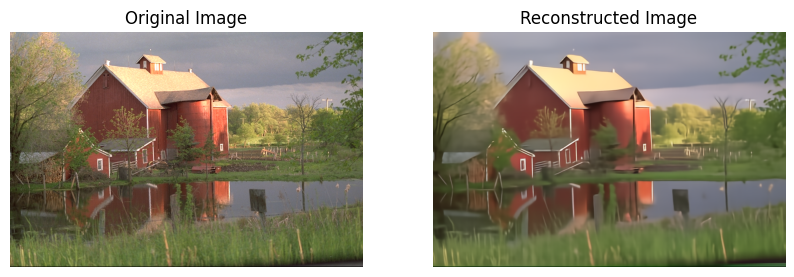

PSNR: 27.838 dB
CBR = 1/48

Trained model - Rayleigh


In [60]:
#input_txt_file = rx_text_base_path +  'reconstructedBinaryVector_im21.txt'          # Give the name of the saved text file
img_no = '22'                                                                       # Give image number in kodak dataset

received_bin_file = rx_binary_base_path + f'received_feature_{trained_model}_img{img_no}.bin'
#convert_txt_to_binary(input_txt_file, received_bin_file)

decode_and_evaluate(received_binary_path = received_bin_file , image_path = f"./Datasets/Kodak/kodim{img_no}.png" , resolution = (512,768), NORMALIZE_CONSTANT=20, int_size=8)

print ( '\n' + f'Trained model - {trained_model.capitalize()}')


**2) With Codebook**

**Transmitter**

In [15]:
codebook_path = './Codebook/codebook_4d_256clusters_rayleigh.npy'
#codebook_path = './Codebook/codebook_4d_512clusters_rayleigh.npy'

chunk_size = 4         # 4d vectors in the codebook
k = 256

img_no = '22'
test_image_path = f"./Datasets/Kodak/kodim{img_no}.png"

tx_binary_base_path = './Binary/Transmitted_Binary/'
trained_model = 'rayleigh' # rayleigh3, awgn10 


indices, _ = encode_image_with_nd_codebook(net, codebook_path, test_image_path, config, device, chunk_size)

indices_np = indices.numpy()  # Convert PyTorch tensor to NumPy array

# Save indices to a binary file using a compact data type 
if k > 256: indices_np.astype(np.uint16).tofile( tx_binary_base_path + f"indices_{chunk_size}d_{k}k_{trained_model}_img{img_no}.bin")  # Use uint16 as 512 fits in 16 bits
else :  indices_np.astype(np.uint8).tofile( tx_binary_base_path + f"indices_{chunk_size}d_{k}k_{trained_model}_img{img_no}.bin")  # Use uint8 as 256 fits in 8 bits

tensor(0.7014)
tensor(-0.2760)
tensor(0.6259)
tensor(-1.3127)


In [19]:
indices

tensor([240, 197,  79,  ...,  35,  60, 105])

In [18]:
#torch.save(indices, 'indices_4d_256k.pt')

**Receiver**

In [58]:
# Convert text to bin

def convert_txt_to_binary(input_txt_file, output_bin_file):
    with open(input_txt_file, 'r') as txt_file:
        bits = txt_file.read().replace('\n', '')  # Read all bits and remove newlines
    
    # Make sure the total number of bits is a multiple of 8
    padded_bits = bits.ljust((len(bits) + 7) // 8 * 8, '0')  # Pad with '0' if necessary
    
    # Group bits into bytes and convert to binary
    byte_data = bytearray(int(padded_bits[i:i + 8], 2) for i in range(0, len(padded_bits), 8))
    
    with open(output_bin_file, 'wb') as bin_file:
        bin_file.write(byte_data)

    print(f"Binary file '{output_bin_file}' created successfully!")

def decode_indices_and_plot (received_binary_path , codebook_path, image_path ,chunk_size=4 ,resolution = (512,768), k=512):

    if k > 256: loaded_indices = np.fromfile(received_binary_path, dtype=np.uint16)   # Use the same dtype as during saving
    else: loaded_indices = np.fromfile(received_binary_path, dtype=np.uint8)

    
    recovered_indices = torch.from_numpy(loaded_indices)   # Convert back to a PyTorch tensor
    recovered_indices = recovered_indices.int()  # Convert to int32 (Convert indices to a compatible type for clamping)

    #valid_indices = torch.clamp(recovered_indices, min=0, max=511)  #  Clamp indices to the valid range  K=512
    valid_indices = torch.clamp(recovered_indices, min=0, max=k-1)
    #valid_indices = recovered_indices

    M = int((resolution[0]*resolution[1])/(16*16))

    input_image, image_name = load_single_image(image_path, config)

    reconstructed = decode_image_with_nd_codebook(valid_indices, M, codebook_path, net, resolution, device, chunk_size)
    
    recon_image = reconstructed.clamp(0, 1)
    psnr_value = calculate_psnr(input_image, recon_image)
    plot_images(input_image, recon_image, image_name)
    print(f"PSNR: {round(psnr_value.item(), 3)} dB")
    print('CBR = 1/48')
    print(f'{chunk_size}d vectors in codebook')

    #save_image(recon_image, f"reconstructed_{image_name}")

rx_text_base_path =  './Binary/Received_Text/'
rx_binary_base_path = './Binary/Received_Binary/'
trained_model = 'rayleigh' # rayleigh = 3 SNR, awgn = 10 SNR

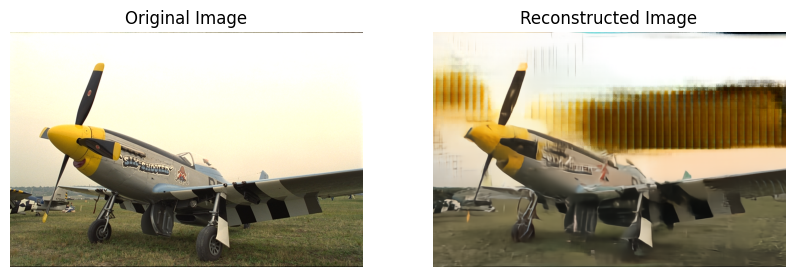

PSNR: 10.389 dB
CBR = 1/48
4d vectors in codebook

Trained model - Rayleigh


In [59]:
# Example usage:
#input_txt_file = rx_text_base_path + 'reconstructedBinaryVector_im20.txt'    # Give name of text file

resolution = (512,768)
#resolution = (768,512)
codebook_path = './Codebook/codebook_4d_512clusters_rayleigh.npy'
#codebook_path = './Codebook/codebook_2d_256clusters_rayleigh.npy'
chunk_size = 4
k= 512
img_no = '20'
received_bin_file = rx_binary_base_path + f'received_indices_{chunk_size}d_{k}k_{trained_model}_img{img_no}.bin'  
image_path = f"./Datasets/Kodak/kodim{img_no}.png"

received_bin_file = 'Binary/Received_Binary/received_indices_rayleigh3_img20.bin'

#convert_txt_to_binary(input_txt_file, received_bin_file)

decode_indices_and_plot(received_binary_path=received_bin_file , codebook_path=codebook_path ,image_path=image_path , chunk_size=chunk_size ,resolution=resolution, k=k)

print ( '\n' + f'Trained model - {trained_model.capitalize()}')

# Simulation for 1 image

Image 'kodim24.png' loaded successfully
tensor(0.7704)
tensor(-0.3561)
tensor(0.4370)
tensor(-1.2749)
Image encoded successfully
Feature passed through channel
Image decoded successfully


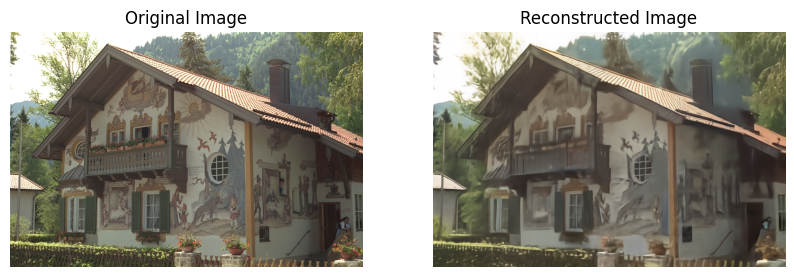

PSNR: 23.34 dB
Rayleigh Channel, SNR = 3 dB
CBR = 1/48


In [14]:
# Encoder

with torch.no_grad():
    
    image_path = "./Datasets/Kodak/kodim24.png" # Replace with your image path
    

    config.isTrain = False
    net.eval()

    input_image, image_name = load_single_image(image_path, config)
    input_image = input_image.to(device)
    print(f"Image '{image_name}' loaded successfully")

    # Step 2: Encode the image
    feature, chan_snr, channel_rate = encode_image(input_image, net)
    print("Image encoded successfully")

#Channel

noisy_feature = pass_through_channel(feature, net, chan_snr)       # Change SNR here if needed
print("Feature passed through channel")
#noisy_feature = feature  # If channel is not simulated

#Decoder

resolution = input_image.shape[2], input_image.shape[3]

with torch.no_grad():
    recon_image = decode_image(noisy_feature, net, chan_snr, resolution)
    print("Image decoded successfully")


cbr_used = "1/"+ str(int((32*48)/channel_rate))
channel_used = "Rayleigh" if args.channel_type == 'rayleigh' else "AWGN" 

recon_image = recon_image.clamp(0, 1)


psnr_value = calculate_psnr(input_image, recon_image)

plot_images(input_image, recon_image, image_name)

print(f"PSNR: {round(psnr_value.item(), 3)} dB")
print(f'{channel_used} Channel, SNR = {chan_snr} dB')
print(f'CBR = {cbr_used}')

In [18]:
print(f'Input Image Shape - {input_image.shape}')
print(f'Channel SNR - {chan_snr}')
print(f'Channel Rate - {channel_rate}')

Input Image Shape - torch.Size([1, 3, 512, 768])
Channel SNR - 3
Channel Rate - 32


In [ ]:
#save_image(recon_image, f"reconstructed_{image_name}")

# Codebook Simulation for 1 image

tensor(1.2199)
tensor(-0.6766)
tensor(0.6640)
tensor(-1.2987)


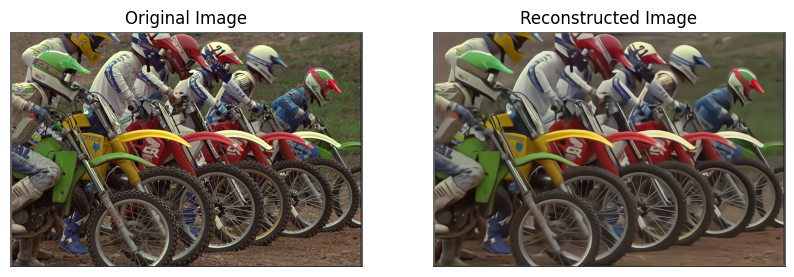

PSNR: 23.696 dB


In [13]:
codebook_path = './Codebook/codebook_4d_256clusters_rayleigh.npy'
chunk_size = 4

test_image_path = "./Datasets/Kodak/kodim05.png"
input_image, image_name = load_single_image(test_image_path, config)
input_image = input_image.to(device)

indices, M = encode_image_with_nd_codebook(net, codebook_path, test_image_path, config, device, chunk_size)

res = (input_image.shape[2], input_image.shape[3])
reconstructed = decode_image_with_nd_codebook(indices, M, codebook_path, net, res, device, chunk_size)

recon_image = reconstructed.clamp(0, 1)
psnr_value = calculate_psnr(input_image, recon_image)
plot_images(input_image, recon_image, image_name)
print(f"PSNR: {round(psnr_value.item(), 3)} dB")


# Codebook with Error Correction

**Transmitter**

In [7]:
# Transmitter

from bitarray import bitarray
import numpy as np
import reedsolo

# Initialize RS codec
r = 127  # Redundancy (symbols per block)
n = 255  # Total symbols per block
data_symbols = n - r  # Data symbols per block
rs = reedsolo.RSCodec(r)


codebook_path = './Codebook/codebook_4d_512clusters_rayleigh.npy'
chunk_size = 4     # 4d vectors in the codebook
k = 512
img_no = '15'

image_path = f"./Datasets/Kodak/kodim{img_no}.png"
input_image, image_name = load_single_image(image_path, config)

indices, _ = encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size)
indices_np = indices.numpy()  # Convert PyTorch tensor to NumPy array

bits_per_index = int(np.ceil(np.log2(k)))  # Calculate bits needed for `k`

# Pack indices into a bit stream
bit_stream = bitarray()
for index in indices:
    bit_stream.extend(format(index, f'0{bits_per_index}b'))

# Convert the bit stream to bytes
packed_data = bit_stream.tobytes()

# Pad for Reed-Solomon compatibility
padding_length = (data_symbols - (len(packed_data) % data_symbols)) % data_symbols
padded_data = packed_data + bytes(padding_length)

# Encode with Reed-Solomon
encoded_data = rs.encode(padded_data)

# Save the encoded data
tx_binary_base_path = './Binary/Transmitted_Binary/'
encoded_file = tx_binary_base_path + f"indices_ec_{chunk_size}d_{k}k_img{img_no}.bin"

with open(encoded_file, "wb") as f:
    f.write(encoded_data)
print(f"Encoded data saved to '{encoded_file}'.\n")

tensor(0.9950)
tensor(-0.0996)
tensor(0.6120)
tensor(-1.2038)
Encoded data saved to './Binary/Transmitted_Binary/indices_ec_4d_512k_img15.bin'.



**Receiver**

Decoding 108 blocks of size 255 bytes each.
Recovered indices saved to './Binary/Received_Binary/recovered_indices_4d_512k_img15.bin'


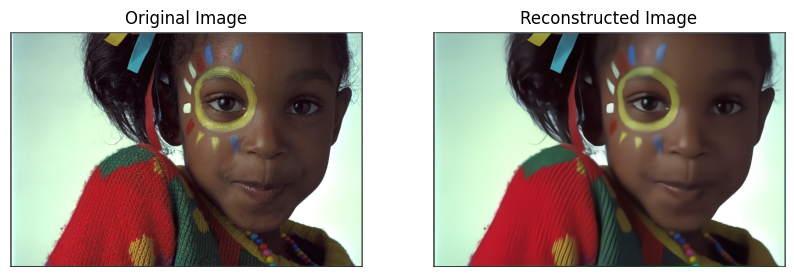

PSNR: 29.39 dB
CBR = 1/48
4d vectors in codebook


In [9]:
# Receiver

from bitarray import bitarray
import numpy as np
import reedsolo

# Initialize RS codec
r = 127  # Redundancy (symbols per block)
n = 255  # Total symbols per block
data_symbols = n - r  # Data symbols per block
rs = reedsolo.RSCodec(r)


codebook_path = './Codebook/codebook_4d_512clusters_rayleigh.npy'
chunk_size = 4     # 4d vectors in the codebook
k = 512
img_no = '15'

image_path = f"./Datasets/Kodak/kodim{img_no}.png"
input_image, image_name = load_single_image(image_path, config)


resolution = (512,768)

original_size = 32 * resolution[0] * resolution[1] // (16 * 16 * chunk_size)  #  (32 x H x W / (16 x 16 x 4))  4 because of 4d codebook

rx_binary_base_path = './Binary/Received_Binary/'
input_file = rx_binary_base_path + f"received_indices_ec_{chunk_size}d_{k}k_img{img_no}.bin"


def decode_blocks(input_file, block_size, data_size, original_size, bits_per_index):
    """
    Decode noisy data from a binary file and reconstruct the original indices.
    """
    decoded_result = bytearray()

    with open(input_file, "rb") as f:
        encoded_data = f.read()

    num_blocks = len(encoded_data) // block_size
    print(f"Decoding {num_blocks} blocks of size {block_size} bytes each.")

    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        block = encoded_data[start:end]

        try:
            decoded_block = rs.decode(block)
            if isinstance(decoded_block, tuple):
                decoded_block = decoded_block[0]
            decoded_result.extend(decoded_block[:data_symbols])
        except reedsolo.ReedSolomonError:
            print(f"Block {i + 1} could not be decoded. Retaining noisy data.")
            decoded_result.extend(block[:data_symbols])

    # Remove padding
    decoded_data = decoded_result[:len(decoded_result) - padding_length]

    # Convert decoded bytes back into a bit stream
    bit_stream = bitarray()
    bit_stream.frombytes(decoded_data)

    # Decode indices from the bit stream
    indices_decoded = []
    i = 0
    while i + bits_per_index <= len(bit_stream):
        indices_decoded.append(int(bit_stream[i:i+bits_per_index].to01(), 2))
        i += bits_per_index

    return np.array(indices_decoded[:original_size], dtype=np.uint16 if bits_per_index > 8 else np.uint8)

decoded_indices = decode_blocks(input_file, block_size=n, data_size=data_symbols, original_size=original_size, bits_per_index=bits_per_index)

# Save recovered indices to a compact binary file
def save_indices_to_binary(indices_np, bits_per_index, file_path):
    """
    Save indices to a compact binary file using the required number of bits per index.
    """
    packed_data = bitarray()
    for idx in indices_np:
        packed_data.extend(format(idx, f'0{bits_per_index}b'))  # Pack indices into binary format
    with open(file_path, "wb") as f:
        packed_data.tofile(f)
    print(f"Recovered indices saved to '{file_path}'")


recovered_file = rx_binary_base_path + f"recovered_indices_{chunk_size}d_{k}k_img{img_no}.bin"
save_indices_to_binary(decoded_indices, bits_per_index, recovered_file)


def decode_indices_and_plot(received_binary_path, codebook_path, image_path, chunk_size=4, resolution=(512, 768), k=512):
    # Calculate bits required for `k`
    bits_per_index = int(np.ceil(np.log2(k)))

    # Load indices from the binary file
    def load_indices_from_binary(file_path, bits_per_index):
        bit_stream = bitarray()
        with open(file_path, 'rb') as f:
            bit_stream.fromfile(f)
        num_indices = len(bit_stream) // bits_per_index  # Calculate the number of indices
        indices = [int(bit_stream[i:i+bits_per_index].to01(), 2) for i in range(0, len(bit_stream), bits_per_index)]
        return np.array(indices[:num_indices], dtype=np.uint16 if bits_per_index > 8 else np.uint8)

    # Load and decode indices
    loaded_indices = load_indices_from_binary(received_binary_path, bits_per_index)
    recovered_indices = torch.from_numpy(loaded_indices)  # Convert back to PyTorch tensor
    recovered_indices = recovered_indices.int()  # Convert to int32 for clamping

    # Clamp indices to the valid range [0, k-1]
    valid_indices = torch.clamp(recovered_indices, min=0, max=k-1)

    # Calculate M (number of 4D vectors) and decode the image
    M = int((resolution[0] * resolution[1]) / (16 * 16))
    input_image, image_name = load_single_image(image_path, config)
    reconstructed = decode_image_with_nd_codebook(valid_indices, M, codebook_path, net, resolution, device, chunk_size)

    # Reconstruct and calculate PSNR
    recon_image = reconstructed.clamp(0, 1)
    psnr_value = calculate_psnr(input_image, recon_image)
    plot_images(input_image, recon_image, image_name)
    print(f"PSNR: {round(psnr_value.item(), 3)} dB")
    print('CBR = 1/48')
    print(f'{chunk_size}d vectors in codebook')


received_bin_file = recovered_file


# Run decoding and reconstruction
decode_indices_and_plot(received_binary_path=received_bin_file, codebook_path=codebook_path, image_path=image_path, chunk_size=chunk_size, resolution=resolution, k=k)





**Simulation**

tensor(1.2199)
tensor(-0.6766)
tensor(0.6640)
tensor(-1.2987)
Encoded data saved to './Testing/error correction/transmitted_data.bin'.

Introducing 6854 errors out of 195840 total bits (ratio = 0.035).
Noisy data saved to './Testing/error correction/noisy_data.bin'.
Decoding 96 blocks of size 255 bytes each.
Block 3 could not be decoded. Retaining noisy data.
Block 5 could not be decoded. Retaining noisy data.
Block 7 could not be decoded. Retaining noisy data.
Block 8 could not be decoded. Retaining noisy data.
Block 9 could not be decoded. Retaining noisy data.
Block 15 could not be decoded. Retaining noisy data.
Block 20 could not be decoded. Retaining noisy data.
Block 22 could not be decoded. Retaining noisy data.
Block 25 could not be decoded. Retaining noisy data.
Block 29 could not be decoded. Retaining noisy data.
Block 33 could not be decoded. Retaining noisy data.
Block 36 could not be decoded. Retaining noisy data.
Block 39 could not be decoded. Retaining noisy data.
Block 

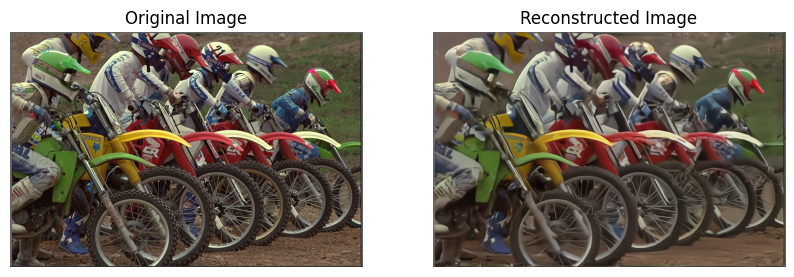

PSNR: 22.06 dB
CBR = 1/48
4D vectors in codebook

Similarity: 90.58%
Errors: 1158 out of 12288 elements


In [9]:
from bitarray import bitarray
import numpy as np
import reedsolo

# Initialize RS codec
r = 127  # Redundancy (symbols per block)
n = 255  # Total symbols per block
data_symbols = n - r  # Data symbols per block
rs = reedsolo.RSCodec(r)

# Parameters


# === Transmitter ===

codebook_path = './Codebook/codebook_4d_256clusters_rayleigh.npy'
chunk_size = 4     # 4d vectors in the codebook
k = 256
img_no = '05'
image_path = f"./Datasets/Kodak/kodim{img_no}.png"

input_image, image_name = load_single_image(image_path, config)
resolution = input_image.shape[2], input_image.shape[3]

indices, _ = encode_image_with_nd_codebook(net, codebook_path, image_path, config, device, chunk_size)
indices_np = indices.numpy()  # Convert PyTorch tensor to NumPy array


bits_per_index = int(np.ceil(np.log2(k)))  # Calculate bits needed for `k`


original_size = 32 * resolution[0] * resolution[1] // (16 * 16 * chunk_size)  # Know original size  (32 x H x W / (16 x 16 x 4))  4 because of 4d codebook



# Pack indices into a bit stream
bit_stream = bitarray()
for index in indices:
    bit_stream.extend(format(index, f'0{bits_per_index}b'))

# Convert the bit stream to bytes
packed_data = bit_stream.tobytes()

# Pad for Reed-Solomon compatibility
padding_length = (data_symbols - (len(packed_data) % data_symbols)) % data_symbols
padded_data = packed_data + bytes(padding_length)

# Encode with Reed-Solomon
encoded_data = rs.encode(padded_data)

# Save the encoded data
encoded_file = './Testing/error correction/transmitted_data.bin'
with open(encoded_file, "wb") as f:
    f.write(encoded_data)
print(f"Encoded data saved to '{encoded_file}'.\n")



# Introduce noise to the encoded data
def add_noise_with_ratio(input_file, output_file, error_ratio):
    """
    Add noise to the encoded data in a binary file and save the result.
    """
    with open(input_file, "rb") as f:
        encoded_data = f.read()

    noisy_data = bytearray(encoded_data)
    total_bits = len(noisy_data) * 8
    num_errors = int(total_bits * error_ratio)

    print(f"Introducing {num_errors} errors out of {total_bits} total bits (ratio = {error_ratio}).")

    for _ in range(num_errors):
        byte_index = np.random.randint(len(noisy_data))
        bit_index = np.random.randint(8)
        noisy_data[byte_index] ^= (1 << bit_index)

    with open(output_file, "wb") as f:
        f.write(noisy_data)

    print(f"Noisy data saved to '{output_file}'.")
    return noisy_data

noisy_file = './Testing/error correction/noisy_data.bin'
noisy_data = add_noise_with_ratio(encoded_file, noisy_file, error_ratio=0.035)

# === Receiver ===

# Decode Reed-Solomon blocks
def decode_blocks(input_file, block_size, data_size, original_size, bits_per_index):
    """
    Decode noisy data from a binary file and reconstruct the original indices.
    """
    decoded_result = bytearray()

    with open(input_file, "rb") as f:
        encoded_data = f.read()

    num_blocks = len(encoded_data) // block_size
    print(f"Decoding {num_blocks} blocks of size {block_size} bytes each.")

    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        block = encoded_data[start:end]

        try:
            decoded_block = rs.decode(block)
            if isinstance(decoded_block, tuple):
                decoded_block = decoded_block[0]
            decoded_result.extend(decoded_block[:data_symbols])
        except reedsolo.ReedSolomonError:
            print(f"Block {i + 1} could not be decoded. Retaining noisy data.")
            decoded_result.extend(block[:data_symbols])

    # Remove padding
    decoded_data = decoded_result[:len(decoded_result) - padding_length]

    # Convert decoded bytes back into a bit stream
    bit_stream = bitarray()
    bit_stream.frombytes(decoded_data)

    # Decode indices from the bit stream
    indices_decoded = []
    i = 0
    while i + bits_per_index <= len(bit_stream):
        indices_decoded.append(int(bit_stream[i:i+bits_per_index].to01(), 2))
        i += bits_per_index

    return np.array(indices_decoded[:original_size], dtype=np.uint16 if bits_per_index > 8 else np.uint8)

decoded_indices = decode_blocks(noisy_file, block_size=n, data_size=data_symbols, original_size=original_size, bits_per_index=bits_per_index)

# Save recovered indices to a compact binary file
def save_indices_to_binary(indices_np, bits_per_index, file_path):
    """
    Save indices to a compact binary file using the required number of bits per index.
    """
    packed_data = bitarray()
    for idx in indices_np:
        packed_data.extend(format(idx, f'0{bits_per_index}b'))  # Pack indices into binary format
    with open(file_path, "wb") as f:
        packed_data.tofile(f)
    print(f"Recovered indices saved to '{file_path}'")


recovered_file = './Testing/error correction/recovered_indices.bin'
save_indices_to_binary(decoded_indices, bits_per_index, recovered_file)


def decode_indices_and_plot(received_binary_path, codebook_path, image_path, chunk_size=4, resolution=(512, 768), k=512):
    # Calculate bits required for `k`
    bits_per_index = int(np.ceil(np.log2(k)))

    # Load indices from the binary file
    def load_indices_from_binary(file_path, bits_per_index):
        bit_stream = bitarray()
        with open(file_path, 'rb') as f:
            bit_stream.fromfile(f)
        num_indices = len(bit_stream) // bits_per_index  # Calculate the number of indices
        indices = [int(bit_stream[i:i+bits_per_index].to01(), 2) for i in range(0, len(bit_stream), bits_per_index)]
        return np.array(indices[:num_indices], dtype=np.uint16 if bits_per_index > 8 else np.uint8)

    # Load and decode indices
    loaded_indices = load_indices_from_binary(received_binary_path, bits_per_index)
    recovered_indices = torch.from_numpy(loaded_indices)  # Convert back to PyTorch tensor
    recovered_indices = recovered_indices.int()  # Convert to int32 for clamping

    # Clamp indices to the valid range [0, k-1]
    valid_indices = torch.clamp(recovered_indices, min=0, max=k-1)

    # Calculate M (number of 4D vectors) and decode the image
    M = int((resolution[0] * resolution[1]) / (16 * 16))
    input_image, image_name = load_single_image(image_path, config)
    reconstructed = decode_image_with_nd_codebook(valid_indices, M, codebook_path, net, resolution, device, chunk_size)

    # Reconstruct and calculate PSNR
    recon_image = reconstructed.clamp(0, 1)
    psnr_value = calculate_psnr(input_image, recon_image)
    plot_images(input_image, recon_image, image_name)
    print(f"PSNR: {round(psnr_value.item(), 3)} dB")
    print('CBR = 1/48')
    print(f'{chunk_size}D vectors in codebook')


received_bin_file = recovered_file


# Run decoding and reconstruction
decode_indices_and_plot(received_binary_path=received_bin_file, codebook_path=codebook_path, image_path=image_path, chunk_size=chunk_size, resolution=resolution, k=k)


def calculate_similarity(indices, decoded_indices):
    num_similar = np.sum(indices == decoded_indices)
    total_elements = indices.size
    similarity = num_similar / total_elements
    return similarity, num_similar, total_elements

similarity,num_similar, total_elements = calculate_similarity(indices_np, decoded_indices)
print(f"\nSimilarity: {similarity:.2%}")
print(f"Errors: {total_elements - num_similar} out of {total_elements} elements")

**Additional Functions**

In [22]:
# calculate number of similar elements between indices and decoded indices and give percentage

def calculate_similarity(indices, decoded_indices):
    num_similar = np.sum(indices == decoded_indices)
    total_elements = indices.size
    similarity = num_similar / total_elements
    return similarity, num_similar, total_elements

similarity,num_similar, total_elements = calculate_similarity(indices_np, decoded_indices)
print(f"\nSimilarity: {similarity:.2%}")
print(f"Errors: {total_elements - num_similar} out of {total_elements} elements")


Similarity: 98.67%
Errors: 164 out of 12288 elements


In [27]:
def calculate_ber(bin_file1, bin_file2):
    with open(bin_file1, 'rb') as file1, open(bin_file2, 'rb') as file2:
        data1 = file1.read()
        data2 = file2.read()
    
    # Calculate the number of bit errors
    bit_errors = sum(bin(int(byte1) ^ int(byte2)).count('1') for byte1, byte2 in zip(data1, data2))
    
    # Calculate the bit error rate
    ber = bit_errors / (8 * len(data1))
    return ber, bit_errors, len(data1)*8



ber, errors, bits = calculate_ber('./Testing/error correction/transmitted_data.bin', './Testing/error correction/noisy_data.bin')
print(f"Bit Error Rate: {ber:.2e}")
print(f"Number of bit errors: {errors}")
print(f"Total number of bits: {bits}")

Bit Error Rate: 2.92e-02
Number of bit errors: 5719
Total number of bits: 195840
